In [1]:
import rebound
import reboundx
import numpy as np
import astropy.units as u

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.interpolate import InterpolatedUnivariateSpline

radeg = np.pi/180

[6.31761632e-15 6.31761632e-15]


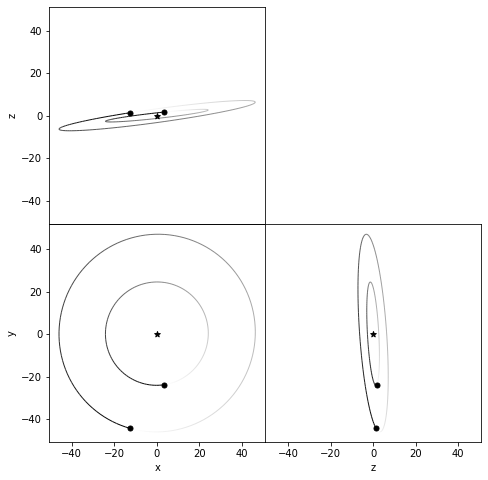

In [9]:
###############
# DEFINITIONS
###############


def add_int(sim, number):
    a_rand = np.random.uniform(10,25,size=number)
    e_rand = np.random.normal(1,.2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.uniform(0,2*np.pi,size=number)
    i_rand = np.random.uniform(0,10,size=number)*radeg
    f_rand = np.random.uniform(0,2*np.pi,size=number)
        
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        fan = f_rand[i]
        has = 'interior_{0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, f=fan, hash=has)
    return

def add_ext(sim, number):
    a_rand = np.random.uniform(35,50,size=number)
    e_rand = np.random.normal(1,.2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.uniform(0,2*np.pi,size=number)
    i_rand = np.random.uniform(0,10,size=number)*radeg
    f_rand = np.random.uniform(0,2*np.pi,size=number)
        
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        fan = f_rand[i]
        has = 'exterior_{0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, f=fan, hash=has)
    return

def yark(simp, rebx_force, particles, N):
    sim = simp.contents
    part = sim.particles
    
    current_time = sim.t + T0
    L_sol = np.exp(log_l(current_time))*0.000235 # solar luminosity in au^2 M_sol/yr^3
    
    sim.move_to_hel()
    for troj in range(num_ast):
    
        i = troj + 1
        
        x = part[i].x  ; y = part[i].y  ; z = part[i].z
        R = troj_radii[i-1]
        m_ast = troj_masses[i-1]
    
        c = 63197.8 # speed of light in au/yr
        r = np.sqrt(x**2 + y**2 + z**2)
        A = (R**2 * L_sol)/(4*m_ast*c)
    
        part[i].ax += (A/r**3) * x
        part[i].ay += (A/r**3) * (0.25*x + y)
        part[i].az += (A/r**3) * z
    return


###########################
###########################
###########################

### SIMULATION

###########################
###########################
###########################

file = np.loadtxt('2solmass_track.txt')
sol_t = file[700:,0]
sol_m = file[700:,1]
sol_l = file[700:,6]

log_l = InterpolatedUnivariateSpline(sol_t, sol_l,k=1)
m_sol = InterpolatedUnivariateSpline(sol_t, sol_m,k=1)

num_int = 1
num_ext = num_int
T0 = sol_t[107]
t_tot = 100000

Nout = 100000
times = np.linspace(0, t_tot, Nout)
mtimes = m_sol(times + T0)

M0 = mtimes[0]
num_ast = num_int + num_ext


##############
# Setting up sim
##############


sim = rebound.Simulation()

sim.add(m=M0,x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='Sun')
add_int(sim, num_int)
add_ext(sim, num_ext)

sim.integrator = "whfast"
sim.dt = .5
sim.testparticle_type = 0
sim.track_energy_offset = 1
#sim.ri_mercurius.hillfac = 5

E0 = sim.calculate_energy()
sim.move_to_com()

ps = sim.particles
fig = rebound.OrbitPlot(sim, slices=True)


#############
# Add mass loss and Yarkovsky using reboundx
#############


rebx = reboundx.Extras(sim)

starmass = reboundx.Interpolator(rebx, times, mtimes, 'spline')

yrkv = rebx.create_force("yarkovsky")

yrkv.force_type = "pos"
yrkv.update_accelerations = yark
rebx.add_force(yrkv)


##############
# Create mass and radius parameters for Trojans
##############


rad_ast = 10                                        # radius in km
troj_radii = np.full(num_ast, rad_ast/1.496e+8)      # gives each asteroid a radius in AU
mass_typicl = 3*(4/3)*np.pi*(rad_ast*100000)**3       # gives typical mass @ this radius, w/ density = 3 g cm^-3
troj_masses = np.full(num_ast, mass_typicl)       # gives array of values around that mass
troj_masses /= 1.9891e33                            # divides each mass by M_sol to get masses in M_sol
print(troj_masses)

#############
# Set up arrays to track elements
#############


x_sol = np.zeros(Nout); y_sol = np.zeros(Nout); z_sol = np.zeros(Nout)
x_sol[0] = ps['Sun'].x
y_sol[0] = ps['Sun'].y
z_sol[0] = ps['Sun'].z


a_vals = np.zeros((num_ast, Nout))
e_vals = np.zeros((num_ast, Nout))
i_vals = np.zeros((num_ast, Nout))
pmvals = np.zeros((num_ast, Nout))
omvals = np.zeros((num_ast, Nout))
o_vals = np.zeros((num_ast, Nout))
lmvals = np.zeros((num_ast, Nout))

energy = np.zeros(Nout)
rhill = np.zeros(Nout)
mass = np.zeros(Nout)
lums = np.zeros(Nout)

x_vals = np.zeros((num_ast, Nout))
y_vals = np.zeros((num_ast, Nout))
z_vals = np.zeros((num_ast, Nout))

for moon in range(num_int):
    a_vals[moon,0] = ps['interior_{0}'.format(moon)].a
    e_vals[moon,0] = ps['interior_{0}'.format(moon)].e
    i_vals[moon,0] = ps['interior_{0}'.format(moon)].inc
    lmvals[moon,0] = ps['interior_{0}'.format(moon)].l
    pmvals[moon,0] = ps['interior_{0}'.format(moon)].pomega
    omvals[moon,0] = ps['interior_{0}'.format(moon)].Omega
    o_vals[moon,0] = ps['interior_{0}'.format(moon)].omega
    x_vals[moon,0] = ps['interior_{0}'.format(moon)].x
    y_vals[moon,0] = ps['interior_{0}'.format(moon)].y
    z_vals[moon,0] = ps['interior_{0}'.format(moon)].z

for moon in range(num_ext):
    a_vals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].a
    e_vals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].e
    i_vals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].inc
    lmvals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].l
    pmvals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].pomega
    omvals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].Omega
    o_vals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].omega
    x_vals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].x
    y_vals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].y
    z_vals[moon + num_int,0] = ps['exterior_{0}'.format(moon)].z

In [10]:
%%time

###########################
###########################
###########################

### RUNNING

###########################
###########################
###########################

for i, time in enumerate(times):
    sim.integrate(time)

    #ps['Sun'].m = starmass.interpolate(rebx, t=sim.t)
    sim.move_to_com()
    
    ###################
    # Tracking elements
    ###################

    mass[i] = ps['Sun'].m
    lums[i] = log_l(sim.t + T0)
    x_sol[i] = ps['Sun'].x
    y_sol[i] = ps['Sun'].y
    z_sol[i] = ps['Sun'].z
    
    energy[i] = sim.calculate_energy()

    for moon in range(num_int):
        a_vals[moon,i] = ps['interior_{0}'.format(moon)].a
        e_vals[moon,i] = ps['interior_{0}'.format(moon)].e
        i_vals[moon,i] = ps['interior_{0}'.format(moon)].inc
        lmvals[moon,i] = ps['interior_{0}'.format(moon)].l
        pmvals[moon,i] = ps['interior_{0}'.format(moon)].pomega
        omvals[moon,i] = ps['interior_{0}'.format(moon)].Omega
        o_vals[moon,i] = ps['interior_{0}'.format(moon)].omega
        x_vals[moon,i] = ps['interior_{0}'.format(moon)].x
        y_vals[moon,i] = ps['interior_{0}'.format(moon)].y
        z_vals[moon,i] = ps['interior_{0}'.format(moon)].z

    for moon in range(num_ext):
        a_vals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].a
        e_vals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].e
        i_vals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].inc
        lmvals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].l
        pmvals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].pomega
        omvals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].Omega
        o_vals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].omega
        x_vals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].x
        y_vals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].y
        z_vals[moon + num_int,i] = ps['exterior_{0}'.format(moon)].z

i_vals/= radeg

dE = abs((energy - E0)/E0)

CPU times: user 39.8 s, sys: 406 ms, total: 40.2 s
Wall time: 40.3 s


/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


In [11]:
a_i = a_vals; e_i = e_vals; i_i = i_vals; pm_i = pmvals; lm_i = lmvals; om_i = omvals; o_i = o_vals
x_i = x_vals; y_i = y_vals; z_i = z_vals
msi = mass; lsi = lums; xsi = x_sol ; ysi = y_sol; zsi = z_sol
dEi = dE; t_i = times

i_dif = np.zeros_like(i_i)
i_int = i_i[:,0]
for i in range(Nout):
    i_dif[:,i] = i_i[:,i] - i_int

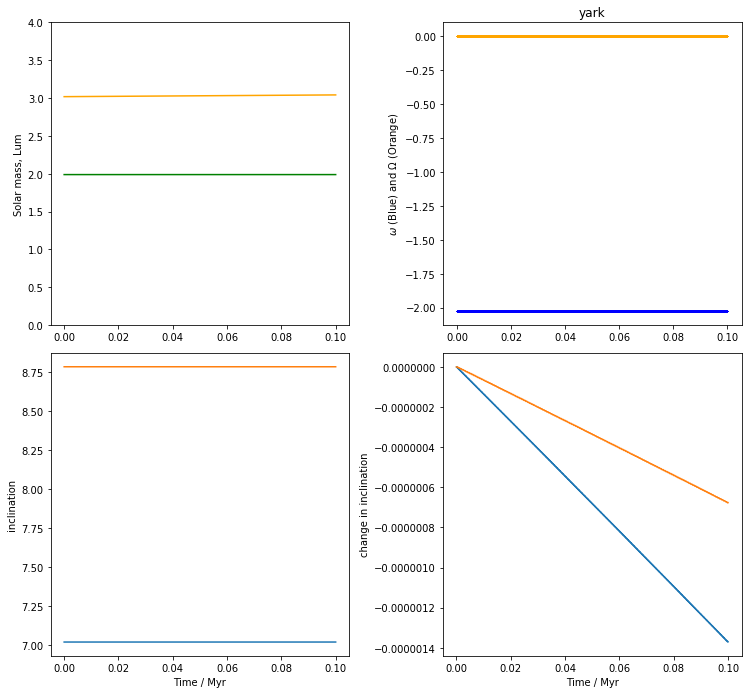

In [12]:
fig, ax = plt.subplots(2,2,figsize=(14*.75,13*.75))

ax[0,0].plot(t_i[1:]/1e6,msi[1:],c='g')
ax[0,0].plot(t_i[1:]/1e6,lsi[1:],c='orange')
ax[0,0].set_ylim(0,4)
ax[0,0].set_ylabel("Solar mass, Lum")

ax[0,1].scatter(t_i[1:]/1e6,(o_i.T[1:,0]),s=0.02,c='orange')
ax[0,1].scatter(t_i[1:]/1e6,(om_i.T[1:,0]),s=0.02,c='b')
ax[0,1].set_ylabel(r'$\omega$ (Blue) and $\Omega$ (Orange)')
ax[0,1].set_title(r'yark')

ax[1,0].plot(t_i[1:]/1e6,i_i.T[1:])
ax[1,0].set_ylabel('inclination')
ax[1,0].set_xlabel('Time / Myr')

ax[1,1].plot(t_i[1:]/1e6,i_dif.T[1:])
#ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('change in inclination')
ax[1,1].set_xlabel('Time / Myr')

fig.tight_layout()
fig.show()

In [13]:
def dadt(a, L, M):
    return 14.4 * (0.1/0.1) * (1/M)**0.5 * (1/20) * (1/3) * 1e-4/1e6 * np.power(10,L) / np.sqrt(a)

def dver(a, L, M):
    n = np.sqrt(4*np.pi**2*M/a**3)
    m = 3*(4/3)*np.pi*(10*100000)**3/1.9891e33
    R = 10/1.496e8
    c = 63197.8
    return -R**2 * np.power(10,L)*0.000235 / (16*c*m*n*a**2) * np.cos(i_i[0,0])

def didt(i,a,L,M):
    n = np.sqrt(4*np.pi**2*M/a**3)
    m = 3*(4/3)*np.pi*(10*100000)**3/1.9891e33
    R = 10/1.496e8
    c = 63197.8
    

In [14]:
t0 = sol_t[107]
tl = 3000000
N_ = 3000000
ts = np.linspace(0, tl, N_)
dt = ts[1] - ts[0]
Om = om_i[0,0]
print(dt)

a_ = np.zeros(N_)
av = np.zeros(N_)
i_ = np.zeros(N_)
l_ = np.zeros(N_)
m_ = np.zeros(N_)
da = np.zeros(N_)
dv = np.zeros(N_)
di = np.zeros(N_)

a_[0] = 10
av[0] = 10
i_[0] = 2.5*radeg

1.0000003333334444


In [15]:
%%time

i = 0 
while i < N_-1:
    l_[i] = log_l(ts[i] + t0)
    m_[i] = 2
    
    at = dadt(a_[i],l_[i],m_[i])
    atv= dver(av[i],l_[i],m_[i])

    da[i+1] = at
    dv[i+1] = atv
    a_[i+1] = at*dt + a_[i]
    av[i+1] = atv*dt+ av[i]

    end = i
    i += 1
    
print(end)

2999998
CPU times: user 1min 9s, sys: 125 ms, total: 1min 9s
Wall time: 1min 9s


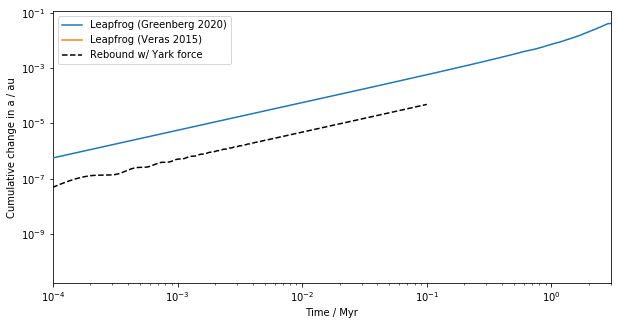

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ts[1:]/1e6, a_[1:] - a_[0],zorder=10)
ax.plot(ts[1:]/1e6, av[1:] - av[0],zorder=10)
ax.plot(t_i[1:]/1e6, a_i.T[1:,0] - a_i.T[0,0],'k',ls='--')
ax.legend(['Leapfrog (Greenberg 2020)','Leapfrog (Veras 2015)', 'Rebound w/ Yark force'], loc='upper left')
ax.set_xlim(0.0001,3)
#ax.set_ylim(0,0.08)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Time / Myr')
ax.set_ylabel("Cumulative change in a / au")
fig.show()

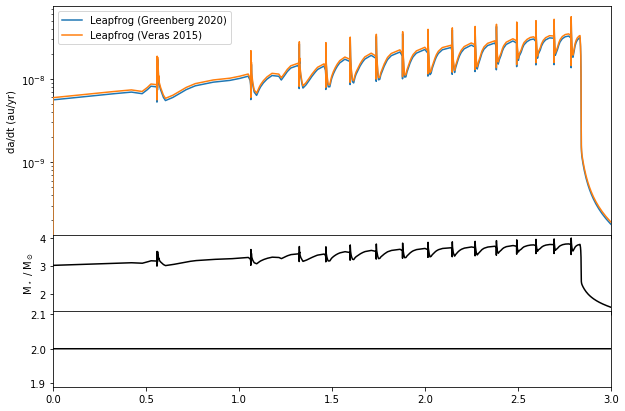

In [377]:
fig, ax = plt.subplots(3,figsize=(10,7),sharex=True,gridspec_kw={'height_ratios': [3, 1,1]})
plt.subplots_adjust(hspace=0)
ax[0].plot(ts[:-1]/1e6, da[:-1],zorder=10)
ax[0].plot(ts[:-1]/1e6, dv[:-1],zorder=10)
ax[1].plot(ts[:-1]/1e6, l_[:-1],zorder=10,c='k')
ax[2].plot(ts[:-1]/1e6, m_[:-1],zorder=10,c='k')
ax[0].legend(['Leapfrog (Greenberg 2020)','Leapfrog (Veras 2015)'], loc='upper left')
ax[0].set_xlim(0,3)
ax[0].set_yscale('log')
ax[1].set_xlabel('Time / Myr')
ax[0].set_ylabel("da/dt (au/yr)")
ax[1].set_ylabel(r"log (L / L$_\odot$)")
ax[1].set_ylabel(r"M$_\star$ / M$_\odot$")
fig.show()

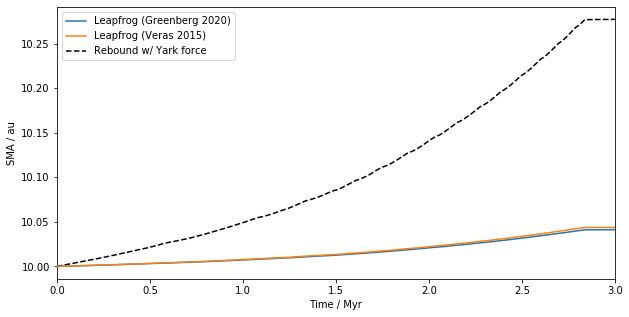

In [378]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ts[1:]/1e6, a_[1:],zorder=10)
ax.plot(ts[1:]/1e6, av[1:],zorder=10)
ax.plot(t_i[1:]/1e6, a_i.T[1:,0],'k',ls='--')
ax.legend(['Leapfrog (Greenberg 2020)','Leapfrog (Veras 2015)', 'Rebound w/ Yark force'], loc='upper left')
ax.set_xlim(0,3)
#ax.set_ylim(0,0.08)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Time / Myr')
ax.set_ylabel("SMA / au")
fig.show()